In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from PIL import Image, ImageOps, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment

import itertools
import os
import sys
import json
import cv2
import numpy as np
import random
from typing import Optional, List, Tuple, Dict, Any
from collections import Counter, defaultdict, deque

import matplotlib.pyplot as plt
import matplotlib.patches as patches

BBox = Tuple[float, float, float, float]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import pathlib
pathlib.PosixPath = pathlib.WindowsPath
sys.path.append("./core/perception/yolov5")
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_boxes
%matplotlib inline

# ===============================YOLO===============================

def load_yolo(weights_path: str, device: Optional[str] = None):
	if device is None:
		device = "cuda" if torch.cuda.is_available() else "cpu"

	yolo = torch.hub.load(
		"ultralytics/yolov5",
		"custom",
		path=weights_path,
		autoshape=False,
		force_reload=True, 
		device='cpu'
	).eval()

	return yolo

@torch.inference_mode()
def detect_objects(
		model,
		pil_image,
		device="cuda" if torch.cuda.is_available() else "cpu",
		imgsz=640,
		conf_thres=0.35,
		iou_thres=0.45,
		id_mapper=None,
):
	model.to(device).eval()

	img0 = np.array(pil_image)[:, :, ::-1]

	stride = model.stride
	if not isinstance(stride, (int, float)):
		stride = max(stride)
	stride = int(stride)

	img = letterbox(img0, imgsz, stride=stride, auto=True)[0]

	img = img[:, :, ::-1].transpose(2, 0, 1)
	img = np.ascontiguousarray(img)
	img = torch.from_numpy(img).to(device).float() / 255.0
	img = img.unsqueeze(0)

	pred = model(img)[0]

	det = non_max_suppression(pred, conf_thres, iou_thres, max_det=300)[0]

	if det is None or not len(det):
		return []

	det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()

	results = [
		{
			"bbox":   [int(x1), int(y1), int(x2), int(y2)],
			"confidence": float(conf),
			"class":     int(cls) if id_mapper is None else id_mapper[int(cls)],
		}
		for (x1, y1, x2, y2, conf, cls) in det.cpu().numpy()
	]
	return results

class_map = {
	0: 'basket',
	1: 'mug',
	2: 'spoon',
	3: 'pot',
	4: 'box',
	5: 'pear',
	6: 'bowl',
	7: 'knife',
	8: 'paper-cup',
	9: 'apple',
	10: 'banana',
	11: 'fork'
}
id_mapper = {
    # Specific ID -> General ID
    0: 9,   # apple_3 -> apple
    1: 5,   # pear_2 -> pear
    2: 5,   # pear_1 -> pear
    3: 4,   # box_1 -> box
    4: 11,  # fork_1 -> fork
    5: 9,   # apple_1 -> apple
    6: 2,   # spoon_2 -> spoon
    7: 0,   # basket_1 -> basket
    8: 1,   # mug_3 -> mug
    9: 8,   # paper-cup_1 -> paper-cup
    10: 3,  # pot_2 -> pot
    11: 3,  # pot_1 -> pot
    12: 0,  # basket_2 -> basket
    13: 11, # fork_2 -> fork
    14: 1,  # mug_1 -> mug
    15: 11, # fork_3 -> fork
    16: 10, # banana_1 -> banana
    17: 10, # banana_2 -> banana
    18: 7,  # knife_1 -> knife
    19: 7,  # knife_3 -> knife
    20: 4,  # box_3 -> box
    21: 10, # banana_3 -> banana
    22: 6,  # bowl_2 -> bowl
    23: 2,  # spoon_1 -> spoon
    24: 6,  # bowl_1 -> bowl
    25: 3,  # pot_3 -> pot
    26: 4,  # box_2 -> box
    27: 9,  # apple_2 -> apple
    28: 0,  # basket_3 -> basket
    29: 8,  # paper-cup_3 -> paper-cup
    30: 5,  # pear_3 -> pear
    31: 6,  # bowl_3 -> bowl
    32: 8,  # paper-cup_2 -> paper-cup
    33: 2,  # spoon_3 -> spoon
    34: 1,  # mug_2 -> mug
    35: 7   # knife_2 -> knife
}
id_mapper = None

# yolo_path = "./core/models/yolo_sim_typewise.pt"
yolo_path = "./core/models/yolo_sim.pt"
yolo = load_yolo(yolo_path)
class_map = {k: ('pot' if v == 'pan' else v) for k, v in yolo.names.items()}

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\arman/.cache\torch\hub\master.zip
YOLOv5  2025-8-26 Python-3.8.10 torch-2.4.1+cpu CPU



In [3]:
def cal_iou(box1: BBox, box2: BBox) -> float:
	"""Calculates IoU for boxes in [xmin, ymin, xmax, ymax] format."""
	# Determine the coordinates of the intersection rectangle
	inter_x1 = max(box1[0], box2[0])
	inter_y1 = max(box1[1], box2[1])
	inter_x2 = min(box1[2], box2[2])
	inter_y2 = min(box1[3], box2[3])

	# Compute the area of intersection
	inter_w = max(0, inter_x2 - inter_x1)
	inter_h = max(0, inter_y2 - inter_y1)
	inter_area = inter_w * inter_h

	# Compute the area of both bounding boxes
	area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
	area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

	# Compute the area of union
	union_area = area1 + area2 - inter_area
	return inter_area / union_area if union_area > 0 else 0.0

def plot_detections(image, detections, class_map=None, ax=None, title=None):
	"""
	Plots an image and overlays bounding boxes from detections on a given ax.
	"""
	if isinstance(image, str):
		try:
			image = Image.open(image)
		except FileNotFoundError:
			print(f"Error: Image file not found at {image}")
			return

	# If no axes is provided, create a new figure and axes
	show_plot = False
	if ax is None:
		fig, ax = plt.subplots(1, figsize=(10, 6))
		show_plot = True

	ax.imshow(image)

	for i, det in enumerate(detections):
		bbox = det['bbox']
		xmin, ymin, xmax, ymax = bbox
		width = xmax - xmin
		height = ymax - ymin

		# Create a Rectangle patch
		rect = patches.Rectangle(
			(xmin, ymin), width, height,
			linewidth=2, edgecolor='lime', facecolor='none'
		)
		ax.add_patch(rect)

		# Add a label
		label_parts = []
		if class_map:
			label_parts.append(f"({i})")
			label_parts.append(class_map.get(det['class'], f"ID {det['class']}"))
		if 'confidence' in det:
			label_parts.append(f"{det['confidence']:.2f}")

		if label_parts:
			ax.text(
				xmin, ymin - 5, " ".join(label_parts),
				color='black', fontsize=8,
				bbox=dict(facecolor='lime', alpha=0.7, pad=1, edgecolor='none')
			)

	ax.axis('off')
	if title:
		ax.set_title(title)

	# Only call plt.show() if we created the figure inside this function
	if show_plot:
		plt.tight_layout()
		plt.show()

def filter_duplicate_detections(
	detections,
	same_class_iou_thres=0.65,
	cross_class_iou_thres=0.90
):
	"""
	Filters out duplicate detections using Non-Maximum Suppression (NMS).

	This function handles both same-class and cross-class duplicates. It keeps
	the detection with the highest confidence and removes others that have a
	high overlap (IoU).

	Args:
		detections (list): A list of detected objects from YOLO.
						Each detection is a dict with 'bbox', 'confidence', and 'class'.
		same_class_iou_thres (float): The IoU threshold for detections of the same class.
		cross_class_iou_thres (float): The IoU threshold for detections of different classes.
									This should be high to only remove clear duplicates.

	Returns:
		list: A new list of filtered detections.
	"""
	# Sort detections by confidence in descending order
	dets = sorted(detections, key=lambda d: d["confidence"], reverse=True)

	kept_detections = []
	while dets:
		# Keep the detection with the highest confidence
		best_det = dets.pop(0)
		kept_detections.append(best_det)

		# Remove other detections that have a high IoU
		remaining_dets = []
		for d in dets:
			iou = cal_iou(best_det['bbox'], d['bbox'])

			# Check for same-class duplicates
			if d['class'] == best_det['class']:
				if iou <= same_class_iou_thres:
					remaining_dets.append(d)
			# Check for cross-class duplicates (high overlap but different class)
			else:
				if iou <= cross_class_iou_thres:
					remaining_dets.append(d)
		dets = remaining_dets

	return kept_detections

def sort_and_validate_detections(label_file_path, det, class_map):
    """
    Sorts and validates detected objects against a ground-truth label file using the
    Hungarian algorithm for optimal assignment.
    """
    with open(label_file_path, 'r') as f:
        labels = json.load(f)

    gt_objects = sorted(labels['objects'], key=lambda x: x['obj_id'])

    if len(det) != len(gt_objects):
        raise ValueError(f"Mismatch in object count. Expected {len(gt_objects)}, but detected {len(det)}.")

    id_to_name = {v: k for k, v in class_map.items()}

    # Group ground-truth and detected objects by class
    gt_by_class = defaultdict(list)
    for gt_obj in gt_objects:
        gt_class_id = id_to_name.get(gt_obj['model_name'])
        if gt_class_id is None:
            raise ValueError(f"Model name '{gt_obj['model_name']}' not in class_map.")
        gt_by_class[gt_class_id].append(gt_obj)

    det_by_class = defaultdict(list)
    for d in det:
        det_by_class[d['class']].append(d)

    # Check if class counts match
    if Counter(k for k in gt_by_class) != Counter(k for k in det_by_class):
        raise ValueError(f"Class mismatch. GT: {Counter(k for k in gt_by_class)}, Det: {Counter(k for k in det_by_class)}")

    sorted_det = [None] * len(gt_objects)

    # For each class, find the optimal assignment
    for class_id, gts in gt_by_class.items():
        dets = det_by_class[class_id]
        if len(gts) != len(dets):
            raise ValueError(f"Mismatch in object count for class {class_id}. Expected {len(gts)}, detected {len(dets)}.")

        # Create a cost matrix (1 - IoU)
        cost_matrix = np.zeros((len(gts), len(dets)))
        for i, gt_obj in enumerate(gts):
            for j, detected_obj in enumerate(dets):
                iou = cal_iou(gt_obj['bbox'], detected_obj['bbox'])
                cost_matrix[i, j] = 1 - iou

        # Use the Hungarian algorithm to find the minimum cost assignment
        gt_indices, det_indices = linear_sum_assignment(cost_matrix)

        # Assign the matched detections
        for gt_idx, det_idx in zip(gt_indices, det_indices):
            gt_obj_id = gts[gt_idx]['obj_id']
            sorted_det[gt_obj_id] = dets[det_idx]

    # Final check to ensure all objects were assigned
    if any(d is None for d in sorted_det):
        unassigned_ids = [i for i, d in enumerate(sorted_det) if d is None]
        raise RuntimeError(f"Failed to assign all objects. Unassigned GT IDs: {unassigned_ids}")

    return sorted_det

def match_target_detections_by_distance(initial_sorted_dets, target_dets):
	"""
	Matches target detections to initial detections by minimizing bbox center distance.

	For classes with a single instance, it performs a direct match. For classes
	with multiple instances, it uses the Hungarian algorithm to find the optimal
	assignment that minimizes the sum of Euclidean distances between the centers
	of the bounding boxes.

	Args:
		initial_sorted_dets (list): A list of sorted detections from the initial scene.
		target_dets (list): A list of filtered detections from the target scene.

	Returns:
		list: A new list of target detections sorted to match the initial detections.

	Raises:
		ValueError: If the object classes in the target scene do not match the initial scene.
	"""
	# --- Validation ---
	initial_classes = Counter(d['class'] for d in initial_sorted_dets)
	target_classes = Counter(d['class'] for d in target_dets)
	if initial_classes != target_classes:
		raise ValueError(f"Object mismatch. Initial: {initial_classes}, Target: {target_classes}")

	# --- Helper Functions ---
	def get_bbox_center(det):
		box = det['bbox']
		return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])

	# --- Setup ---
	sorted_target_list = [None] * len(initial_sorted_dets)

	# Group initial and target detections by class
	initial_by_class = defaultdict(list)
	for i, det in enumerate(initial_sorted_dets):
		initial_by_class[det['class']].append({'idx': i, 'det': det})

	target_by_class = defaultdict(list)
	for det in target_dets:
		target_by_class[det['class']].append(det)

	# --- Match objects ---
	for class_id, initial_dets in initial_by_class.items():
		target_dets_for_class = target_by_class[class_id]

		if len(initial_dets) == 1:
			# Simple case: unique object
			sorted_target_list[initial_dets[0]['idx']] = target_dets_for_class[0]
		else:
			# Complex case: multiple objects of the same class
			# Create a cost matrix of distances
			num_instances = len(initial_dets)
			cost_matrix = np.zeros((num_instances, num_instances))

			for i in range(num_instances):
				for j in range(num_instances):
					center_initial = get_bbox_center(initial_dets[i]['det'])
					center_target = get_bbox_center(target_dets_for_class[j])
					cost_matrix[i, j] = np.linalg.norm(center_initial - center_target)

			# Find the optimal assignment using the Hungarian algorithm
			row_ind, col_ind = linear_sum_assignment(cost_matrix)

			# Assign the matched objects
			for i, j in zip(row_ind, col_ind):
				initial_idx = initial_dets[i]['idx']
				sorted_target_list[initial_idx] = target_dets_for_class[j]

	return sorted_target_list


In [4]:
%matplotlib inline
from core.sim.rearrangemet_loader import select_rearrangement_dir, visualize_rearrangement

# ===============================SRD===============================

def load_model(checkpoint_path: str, num_classes: int=3):
	# Model (identical architecture to training) ------------------------------
	# resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
	resnet = models.resnet50(weights=None)

	old_conv = resnet.conv1
	new_conv = nn.Conv2d(
		5,
		old_conv.out_channels,
		kernel_size=old_conv.kernel_size,
		stride=old_conv.stride,
		padding=old_conv.padding,
		bias=False,
	)
	with torch.no_grad():
		new_conv.weight[:, :3] = old_conv.weight          # copy RGB weights
		mean_w = old_conv.weight.mean(dim=1, keepdim=True)
		new_conv.weight[:, 3:5] = mean_w.repeat(1, 2, 1, 1)
	resnet.conv1 = new_conv

	resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
	resnet = resnet.to(DEVICE)

	# Load checkpoint ----------------------------------------------------------
	ckpt = torch.load(checkpoint_path, map_location=DEVICE)
	resnet.load_state_dict(ckpt["model_state_dict"])
	# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
	start_epoch = ckpt["epoch"] + 1
	best_val_acc = ckpt["best_val_acc"]
	global_step = ckpt.get("global_step", {"train": 0, "val": 0})
	print(f"\n🔄 Loaded checkpoint {checkpoint_path}")

	resnet.eval()
	return resnet

def union_box(box1: BBox, box2: BBox) -> BBox:
	"""Return the bounding rectangle that encloses *both* input boxes."""
	xmin = min(box1[0], box2[0])
	ymin = min(box1[1], box2[1])
	xmax = max(box1[2], box2[2])
	ymax = max(box1[3], box2[3])
	return xmin, ymin, xmax, ymax

def bbox_map(mask: np.ndarray) -> np.ndarray:
	"""Binary image with ones inside the bounding box of *mask*."""
	y, x = np.where(mask > 0)
	if len(x) == 0:
		return np.zeros_like(mask, dtype=np.uint8)
	x1, x2 = x.min(), x.max()
	y1, y2 = y.min(), y.max()
	out = np.zeros_like(mask, dtype=np.uint8)
	out[y1 : y2 + 1, x1 : x2 + 1] = 1
	return out

def build_five_channel(mask1: np.ndarray, mask2: np.ndarray) -> np.ndarray:
	"""Return 5×H×W float32 tensor for a mask pair."""
	overlap = np.logical_and(mask1, mask2).astype(np.uint8)
	ch = np.stack(
		[
			mask1.astype(np.float32),
			mask2.astype(np.float32),
			bbox_map(mask1).astype(np.float32),
			bbox_map(mask2).astype(np.float32),
			overlap.astype(np.float32),
		],
		axis=0,
	)
	return ch

def resize_tensor(t: np.ndarray, size_xy: Tuple[int, int]) -> np.ndarray:
	"""Nearest-neighbour resize of C×H×W to *size_xy* (wxh)."""
	c, h, w = t.shape
	out = np.empty((c, size_xy[1], size_xy[0]), dtype=np.float32)
	for i in range(c):
		out[i] = cv2.resize(t[i], size_xy, interpolation=cv2.INTER_NEAREST)
	return out

def predict_single(model, backend: str, tensor5: np.ndarray) -> np.ndarray:
	"""Forward pass of a *single* 5-channel sample – returns 3-element numpy."""
	if backend == "torch":
		import torch

		x = torch.from_numpy(tensor5).unsqueeze(0)
		with torch.no_grad():
			y = model(x).squeeze(0).cpu().numpy()
		return y

	x = tensor5.transpose(1, 2, 0)[None, ...]
	y = model.predict(x, verbose=0)[0]
	return y

def classify_pair(vec1: np.ndarray, vec2: np.ndarray) -> str:
	"""Return “mask2_parent”, “mask1_parent” or “none”."""
	v1 = vec1.copy()
	v1[0], v1[1] = v1[1], v1[0]
	combined = v1 + vec2
	onehot = np.zeros_like(combined, dtype=int)
	onehot[np.argmax(combined)] = 1
	if onehot[0] == 1:
		return "mask2_parent"
	if onehot[1] == 1:
		return "mask1_parent"
	return "none"

def bbox_to_slice(bbox):
	x1, y1, x2, y2 = map(int, bbox)
	return slice(y1, y2), slice(x1, x2)

def square_bbox(bbox, img_w, img_h):
	x1, y1, x2, y2 = map(float, bbox)
	w, h = x2 - x1, y2 - y1
	cx, cy = x1 + w / 2, y1 + h / 2
	side = max(w, h)
	half = side / 2
	new_x1, new_y1 = cx - half, cy - half
	new_x2, new_y2 = cx + half, cy + half

	new_x1, new_y1 = max(0, new_x1), max(0, new_y1)
	new_x2, new_y2 = min(img_w, new_x2), min(img_h, new_y2)

	new_w, new_h = new_x2 - new_x1, new_y2 - new_y1
	if new_w != side:
		diff = side - new_w
		if new_x1 - diff >= 0:
			new_x1 -= diff
		else:
			new_x2 += diff
	if new_h != side:
		diff = side - new_h
		if new_y1 - diff >= 0:
			new_y1 -= diff
		else:
			new_y2 += diff
	return [int(round(v)) for v in (new_x1, new_y1, new_x2, new_y2)]

def _filter_transitive_pairs(edges: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
	adj: dict[int, set[int]] = defaultdict(set)
	for p, c in edges:
		adj[p].add(c)

	keep = []
	for parent, child in edges:
		queue = deque(adj[parent] - {child})
		visited = set(queue)
		redundant = False
		while queue and not redundant:
			node = queue.popleft()
			if node == child:
				redundant = True
				break
			queue.extend(n for n in adj[node] if n not in visited)
			visited.update(adj[node])
		if not redundant:
			keep.append((parent, child))
	return keep

def compute_scene_relation_graph(
    image_path: str,
    bboxes: list,
    model,
    iou_threshold: float = 0.04,
    device: str = DEVICE,
    target_size: tuple = (224, 224),
) -> list:
    """
    Computes parent-child relations for a scene given an image and a list of bounding boxes.

    Args:
        image_path (str): Path to the scene image.
        bboxes (list): List of bounding boxes (each as [xmin, ymin, xmax, ymax]).
        model: The SRI model.
        iou_threshold (float): IoU threshold for considering pairs.
        device (str): Device for model inference.
        target_size (tuple): Size to which crops are resized.

    Returns:
        List[Tuple[int, int]]: List of (parent_idx, child_idx) pairs.
    """
    img = Image.open(image_path).convert("RGB")
    img_w, img_h = img.size
    img_arr = np.asarray(img, dtype=np.float32) / 255.0

    ids = list(range(len(bboxes)))
    parent_pairs = []

    for id1, id2 in itertools.combinations(ids, 2):
        b1 = tuple(map(float, bboxes[id1]))
        b2 = tuple(map(float, bboxes[id2]))
        un_mask = union_box(b1, b2)

        if cal_iou(b1, b2) <= iou_threshold:
            continue

        mask1 = np.zeros((img_h, img_w), dtype=np.float32)
        mask2 = np.zeros((img_h, img_w), dtype=np.float32)
        mask1[bbox_to_slice(b1)] = 1.0
        mask2[bbox_to_slice(b2)] = 1.0

        sq_bbox = square_bbox(un_mask, img_w, img_h)
        s = bbox_to_slice(sq_bbox)
        rgb_crop = img_arr[s]
        m1_crop = mask1[s][..., None]
        m2_crop = mask2[s][..., None]

        rgb_resized = cv2.resize(rgb_crop, target_size, interpolation=cv2.INTER_LINEAR)
        m1_resized = cv2.resize(m1_crop, target_size, interpolation=cv2.INTER_NEAREST)
        m2_resized = cv2.resize(m2_crop, target_size, interpolation=cv2.INTER_NEAREST)

        stacked12 = np.concatenate([rgb_resized, m1_resized[..., None], m2_resized[..., None]], axis=-1)
        stacked21 = np.concatenate([rgb_resized, m2_resized[..., None], m1_resized[..., None]], axis=-1)

        tensor12 = torch.from_numpy(stacked12).permute(2, 0, 1).unsqueeze(0).to(device)
        tensor21 = torch.from_numpy(stacked21).permute(2, 0, 1).unsqueeze(0).to(device)

        v12 = model(tensor12).squeeze(0).cpu().detach().numpy()
        v21 = model(tensor21).squeeze(0).cpu().detach().numpy()
        relation = classify_pair(v12, v21)

        if relation == "mask2_parent":
            parent_pairs.append((id2, id1))
        elif relation == "mask1_parent":
            parent_pairs.append((id1, id2))

    parent_pairs = _filter_transitive_pairs(parent_pairs)
    return parent_pairs


In [5]:
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
from typing import List, Dict
import pybullet as p
import pybullet_data
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
from core.env.scene_manager import OBJECTS, Indices, SceneManager
from core.sim.rearrangemet_loader import world_to_grid_coords
OBJS_DIR = os.path.join('core', 'sim', 'objects')

# A type hint for clarity
Detection = Dict[str, any]

def _apply_same_class_nms(detections: List[Detection], thresh: float) -> List[Detection]:
    """Applies Non-Maximum Suppression to a list of detections on a per-class basis."""
    grouped_dets = defaultdict(list)
    for det in detections:
        grouped_dets[det['class']].append(det)

    final_detections = []
    for class_id, dets in grouped_dets.items():
        dets = sorted(dets, key=lambda d: d['confidence'], reverse=True)
        kept_dets = []
        while dets:
            best_det = dets.pop(0)
            kept_dets.append(best_det)
            dets = [d for d in dets if cal_iou(best_det['bbox'], d['bbox']) <= thresh]
        final_detections.extend(kept_dets)
    return final_detections

def _reciprocal_match(
    detections_A: List[Detection], 
    detections_B: List[Detection], 
    confusable_groups: List[set] = None
) -> (List[Detection], List[Detection]):
    """Finds the best conceptual matches between two scenes."""
    matched_A, matched_B = [], []
    matched_indices_A, matched_indices_B = set(), set()

    # --- Exact Matching First ---
    grouped_A = defaultdict(list)
    for i, det in enumerate(detections_A):
        grouped_A[det['class']].append({'det': det, 'idx': i})

    grouped_B = defaultdict(list)
    for i, det in enumerate(detections_B):
        grouped_B[det['class']].append({'det': det, 'idx': i})
    
    all_classes = set(grouped_A.keys()) | set(grouped_B.keys())
    for class_id in all_classes:
        dets_A, dets_B = grouped_A.get(class_id, []), grouped_B.get(class_id, [])
        if not dets_A or not dets_B:
            continue
        
        cost_matrix = np.zeros((len(dets_A), len(dets_B)))
        for i in range(len(dets_A)):
            for j in range(len(dets_B)):
                cost_matrix[i, j] = 1 - (dets_A[i]['det']['confidence'] * dets_B[j]['det']['confidence'])
        
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        for i, j in zip(row_ind, col_ind):
            matched_A.append(dets_A[i]['det'])
            matched_B.append(dets_B[j]['det'])
            matched_indices_A.add(dets_A[i]['idx'])
            matched_indices_B.add(dets_B[j]['idx'])

    # --- Confusion Matching for the Remainder ---
    if confusable_groups:
        unmatched_A = [d for i, d in enumerate(detections_A) if i not in matched_indices_A]
        unmatched_B = [d for i, d in enumerate(detections_B) if i not in matched_indices_B]
        for group in confusable_groups:
            group_dets_A = [d for d in unmatched_A if d['class'] in group]
            group_dets_B = [d for d in unmatched_B if d['class'] in group]
            if not group_dets_A or not group_dets_B:
                continue
            
            cost_matrix = np.zeros((len(group_dets_A), len(group_dets_B)))
            for i in range(len(group_dets_A)):
                for j in range(len(group_dets_B)):
                    cost_matrix[i, j] = 1 - (group_dets_A[i]['confidence'] * group_dets_B[j]['confidence'])
            
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            for i, j in zip(row_ind, col_ind):
                det_A, det_B = group_dets_A[i], group_dets_B[j]
                if det_A['confidence'] >= det_B['confidence']:
                    det_B['class'] = det_A['class']
                else:
                    det_A['class'] = det_B['class']
                matched_A.append(det_A)
                matched_B.append(det_B)
                
    return matched_A, matched_B

def _apply_cross_class_nms_on_pairs(
    detections_A: List[Detection], 
    detections_B: List[Detection], 
    thresh: float
) -> (List[Detection], List[Detection]):
    """Applies a final cross-class NMS on paired detections using their combined confidence."""
    if not detections_A:
        return [], []

    paired_detections = []
    for i, (det_A, det_B) in enumerate(zip(detections_A, detections_B)):
        combined_confidence = (det_A['confidence'] + det_B['confidence']) / 2.0
        paired_detections.append({'det_A': det_A, 'combined_confidence': combined_confidence, 'original_idx': i})
    
    sorted_pairs = sorted(paired_detections, key=lambda x: x['combined_confidence'], reverse=True)
    
    kept_indices = []
    while sorted_pairs:
        best_pair = sorted_pairs.pop(0)
        kept_indices.append(best_pair['original_idx'])
        sorted_pairs = [p for p in sorted_pairs if cal_iou(best_pair['det_A']['bbox'], p['det_A']['bbox']) <= thresh]
        
    final_A = [detections_A[i] for i in kept_indices]
    final_B = [detections_B[i] for i in kept_indices]
    return final_A, final_B

def align_and_filter_detections(
    detections_A: List[Detection], 
    detections_B: List[Detection], 
    same_class_iou_thresh: float = 0.5,
    cross_class_iou_thresh: float = 0.6,
    confusable_groups: List[set] = None
) -> (List[Detection], List[Detection]):
    """
    Orchestrates the full pipeline for aligning and filtering detections from two scenes.
    
    Pipeline Steps:
    1.  Apply per-class NMS to each scene to remove same-class duplicates.
    2.  Perform reciprocal matching to find a conceptually consistent set of objects.
    3.  Apply a final cross-class NMS on the matched pairs to remove spatial overlaps.
    """
    # Step 1: Per-class NMS on each scene independently
    clean_A = _apply_same_class_nms(detections_A, same_class_iou_thresh)
    clean_B = _apply_same_class_nms(detections_B, same_class_iou_thresh)

    # Step 2: Reciprocal matching to get conceptually aligned pairs
    matched_A, matched_B = _reciprocal_match(clean_A, clean_B, confusable_groups)
    
    # Step 3: Cross-class NMS on the final pairs to resolve spatial conflicts
    final_A, final_B = _apply_cross_class_nms_on_pairs(matched_A, matched_B, cross_class_iou_thresh)

    print(f"Pipeline complete. Final object count: {len(final_A)}.")
    return final_A, final_B

def create_x_from_det(det_init, det_trgt, init_pairs, trgt_pairs, viewpoint_id, class_map):
	num_objects = len(det_init)

	sim = PyBulletSim(p.DIRECT)
	grid_size = (100, 100)
	table = load_table_urdf(OBJS_DIR, grid_size)
	z = get_object_extents(table)[2]
	cam = CameraManager()
	cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=viewpoint_id)

	x_init = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	x_trgt = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	for i in range(len(det_init)):
		model_name = class_map[det_init[i]['class']]
		label = next((k for k, v in OBJECTS.items() if v['name'] == model_name), None)
		size = OBJECTS[label]['size']
		bbox = det_init[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_init[i, 0] = label
		x_init[i, 1] = size[0]
		x_init[i, 2] = size[1]
		x_init[i, 3] = grid_pos[0]
		x_init[i, 4] = grid_pos[1]

		bbox = det_trgt[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_trgt[i, 0] = label
		x_trgt[i, 1] = size[0]
		x_trgt[i, 2] = size[1]
		x_trgt[i, 3] = grid_pos[0]
		x_trgt[i, 4] = grid_pos[1]
	
	sim.close()

	# print("Initial Scene")
	for stacked_id, base_id in init_pairs:
		# print(f"  {stacked_id}  ⟶  {base_id}")
		x_init[stacked_id, Indices.RELATION.start + base_id] = 1
		x_init[stacked_id, Indices.COORD] = x_init[base_id, Indices.COORD].clone()

	# print("Target Scene")
	for stacked_id, base_id in trgt_pairs:
		# print(f"  {stacked_id}  ⟶  {base_id}")
		x_trgt[stacked_id, Indices.RELATION.start + base_id] = 1
		x_trgt[stacked_id, Indices.COORD] = x_trgt[base_id, Indices.COORD].clone()

	return x_init, x_trgt

def validate_stack_relations(meta_path, x_init, x_trgt):
    """
    Validates the detected stacking relations in x_init and x_trgt against the ground truth from meta.json.

    Args:
        meta_path (str): Path to the meta.json file.
        x_init (torch.Tensor): The state tensor for the initial scene.
        x_trgt (torch.Tensor): The state tensor for the target scene.

    Returns:
        bool: True if detected relations match ground truth for both scenes, False otherwise.
    """
    with open(meta_path, 'r') as f:
        meta = json.load(f)

    num_objects = len(meta['objects'])
    all_correct = True

    # --- Extract Ground Truth Relations ---
    gt_init_relations = set()
    gt_trgt_relations = set()
    for obj in meta['objects']:
        child_id = obj['object_id']
        if obj['initial_base_id'] is not None:
            parent_id = obj['initial_base_id']
            gt_init_relations.add((child_id, parent_id))
        if obj['target_base_id'] is not None:
            parent_id = obj['target_base_id']
            gt_trgt_relations.add((child_id, parent_id))

    # --- Extract Detected Relations ---
    detected_init_relations = set()
    detected_trgt_relations = set()
    for child_id in range(num_objects):
        # Check initial relations
        init_parent_ids = torch.where(x_init[child_id, Indices.RELATION] == 1)[0]
        for parent_id in init_parent_ids:
            detected_init_relations.add((child_id, int(parent_id)))

        # Check target relations
        trgt_parent_ids = torch.where(x_trgt[child_id, Indices.RELATION] == 1)[0]
        for parent_id in trgt_parent_ids:
            detected_trgt_relations.add((child_id, int(parent_id)))

    # --- Compare and Print Results ---
    print("\n--- Stack Relation Validation ---")

    # Initial Scene
    print("\n[Initial Scene]")
    print(f"  - Ground Truth: {sorted(list(gt_init_relations)) if gt_init_relations else 'No stacks'}")
    print(f"  - Detected:     {sorted(list(detected_init_relations)) if detected_init_relations else 'No stacks'}")
    if gt_init_relations == detected_init_relations:
        print("  - ✅ Correct")
    else:
        print("  - ❌ Incorrect")
        all_correct = False
        missing = gt_init_relations - detected_init_relations
        extra = detected_init_relations - gt_init_relations
        if missing:
            print(f"    - Missing relations: {sorted(list(missing))}")
        if extra:
            print(f"    - Extra relations:   {sorted(list(extra))}")

    # Target Scene
    print("\n[Target Scene]")
    print(f"  - Ground Truth: {sorted(list(gt_trgt_relations)) if gt_trgt_relations else 'No stacks'}")
    print(f"  - Detected:     {sorted(list(detected_trgt_relations)) if detected_trgt_relations else 'No stacks'}")
    if gt_trgt_relations == detected_trgt_relations:
        print("  - ✅ Correct")
    else:
        print("  - ❌ Incorrect")
        all_correct = False
        missing = gt_trgt_relations - detected_trgt_relations
        extra = detected_trgt_relations - gt_trgt_relations
        if missing:
            print(f"    - Missing relations: {sorted(list(missing))}")
        if extra:
            print(f"    - Extra relations:   {sorted(list(extra))}")
    print("-" * 33 + "\n")
    return all_correct

def scene_perception(
		yolo, model, folder_path, class_map, 
		confidence_thresh=0.4, same_class_iou_thresh=0.5, 
		cross_class_iou_thresh=0.5, confusable_groups=[], 
		verbose=0, return_x=False
	):
	meta_path = os.path.join(folder_path, 'meta.json')
	initial_labels_path = os.path.join(folder_path, 'initial_labels.json')
	init_img_path = os.path.join(folder_path, 'initial_image.png')
	trgt_img_path = os.path.join(folder_path, 'target_image.png')

	init_img = Image.open(init_img_path).convert("RGB")
	trgt_img  = Image.open(trgt_img_path).convert("RGB")

	# Get RAW detections first (use a lower confidence threshold to get more candidates)
	raw_det_init = detect_objects(yolo, init_img, conf_thres=confidence_thresh)
	raw_det_trgt = detect_objects(yolo, trgt_img, conf_thres=confidence_thresh)

	# Mutual filtering by confidence to ensure both scenes agree on the objects
	filtered_det_init, filtered_det_trgt = align_and_filter_detections(
        raw_det_init,
        raw_det_trgt,
        same_class_iou_thresh=same_class_iou_thresh,
        cross_class_iou_thresh=cross_class_iou_thresh,
        confusable_groups=confusable_groups
    )

	if verbose == 2:
		# Visualize the raw and filtered detections
		fig, axes = plt.subplots(2, 2, figsize=(10, 8))
		plot_detections(init_img_path, raw_det_init, class_map, ax=axes[0, 0], title="Raw Initial Detections")
		plot_detections(trgt_img_path, raw_det_trgt, class_map, ax=axes[0, 1], title="Raw Target Detections")
		plot_detections(init_img_path, filtered_det_init, class_map, ax=axes[1, 0], title="Initial Scene Filtered")
		plot_detections(trgt_img_path, filtered_det_trgt, class_map, ax=axes[1, 1], title="Target Scene Filtered")
		plt.tight_layout()
		plt.show()

	# Sort and validate detections against the ground truth labels
	try:
		sorted_det_init = sort_and_validate_detections(initial_labels_path, filtered_det_init, class_map)
	except ValueError as ve:
		if verbose == 1:
			fig, axes = plt.subplots(2, 2, figsize=(10, 8))
			plot_detections(init_img_path, raw_det_init, class_map, ax=axes[0, 0], title="Raw Initial Detections")
			plot_detections(trgt_img_path, raw_det_trgt, class_map, ax=axes[0, 1], title="Raw Target Detections")
			plot_detections(init_img_path, filtered_det_init, class_map, ax=axes[1, 0], title="Initial Scene Filtered")
			plot_detections(trgt_img_path, filtered_det_trgt, class_map, ax=axes[1, 1], title="Target Scene Filtered")
			plt.tight_layout()
			plt.show()
		print(f"Skipping scene '{folder_path}' due to error in initial detections: {ve}")
		return -1

	sorted_det_trgt = match_target_detections_by_distance(sorted_det_init, filtered_det_trgt)

	if verbose == 2:
		fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
		plot_detections(init_img_path, sorted_det_init, class_map, ax=ax1, title="Initial Scene Detections")
		plot_detections(trgt_img_path, sorted_det_trgt, class_map, ax=ax2, title="Target Scene Detections (Matched)")
		plt.tight_layout()
		plt.show()

	with open(initial_labels_path, 'r') as f:
		labels = json.load(f)
	cam_info = labels['camera_info']
	viewpoint_id = cam_info['viewpoint_id']

	init_bboxes = [o["bbox"] for o in sorted_det_init]
	init_pairs = compute_scene_relation_graph(init_img_path, init_bboxes, model)
	trgt_bboxes = [o["bbox"] for o in sorted_det_trgt]
	trgt_pairs = compute_scene_relation_graph(trgt_img_path, trgt_bboxes, model)
	x_init, x_trgt = create_x_from_det(sorted_det_init, sorted_det_trgt, init_pairs, trgt_pairs, viewpoint_id, class_map)
	# num_objects = x_init.shape[0]
	# grid_size = (100, 100)
	# env = SceneManager(num_objects=num_objects, grid_size=grid_size, verbose=0)
	# env.reset(x_init, x_trgt)
	# env.render()
	if not validate_stack_relations(meta_path, x_init, x_trgt):
		if return_x:
			return x_init, x_trgt
		return 0
	
	if return_x:
		return x_init, x_trgt
	return 1

dataset_dir = "./dataset-sim"
model = load_model("./core/models/SRI.pt")
model = model.to(DEVICE)


🔄 Loaded checkpoint ./core/models/SRI.pt


# Perception

In [ ]:
folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=2390, viewpoint_id=None)
# visualize_rearrangement(dataset_dir, scene_id=scene_id,figsize=(9, 4), show_bbx=False)
utensils = {'fork', 'knife', 'spoon'}
fruits = {'apple', 'pear'}
bowls = {'bowl', 'pot'}
utensil_group = {k for k, v in class_map.items() if v in utensils}
fruit_group = {k for k, v in class_map.items() if v in fruits}
bowl_group = {k for k, v in class_map.items() if v in bowls}
confusable_groups = [utensil_group, fruit_group, bowl_group]
scene_perception(
	yolo, model, folder_path, class_map, 
	confidence_thresh=0.3, same_class_iou_thresh=0.7, cross_class_iou_thresh=0.7,
	confusable_groups=confusable_groups, verbose=0
);

0 -------------------------rearrangement_02101-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: No stacks
  - Detected:     No stacks
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(6, 8)]
  - Detected:     [(6, 8)]
  - ✅ Correct
---------------------------------



1 -------------------------rearrangement_02454-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(2, 7), (3, 2)]
  - Detected:     [(2, 7), (3, 2)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(0, 7), (2, 5), (3, 1)]
  - Detected:     [(0, 7), (2, 5), (3, 1)]
  - ✅ Correct
---------------------------------



2 -------------------------rearrangement_02287-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(8, 4)]
  - Detected:     [(8, 4)]
  - ✅ Correct

[T

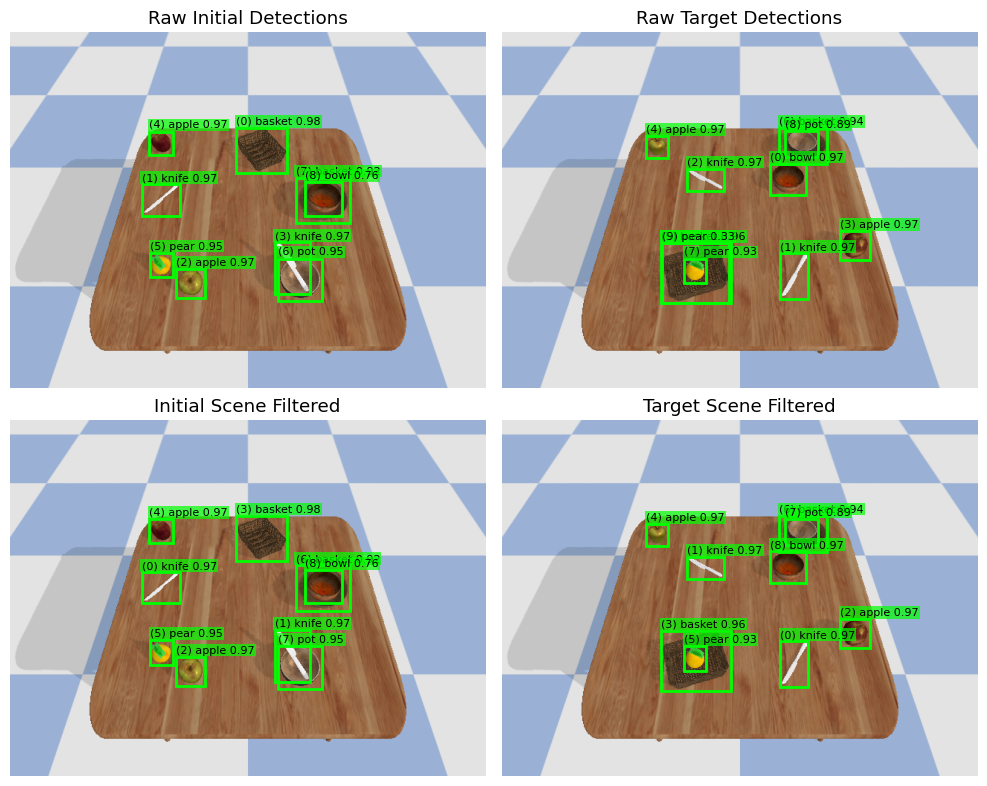

Skipping scene './dataset-sim\rearrangement_02379' due to error in initial detections: Class mismatch. GT: Counter({11: 1, 7: 1, 6: 1, 9: 1, 2: 1}), Det: Counter({7: 1, 9: 1, 2: 1, 11: 1, 4: 1, 6: 1})


7 -------------------------rearrangement_02086-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(1, 6)]
  - Detected:     [(1, 6)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(4, 0), (5, 7)]
  - Detected:     [(4, 0), (5, 2)]
  - ❌ Incorrect
    - Missing relations: [(5, 7)]
    - Extra relations:   [(5, 2)]
---------------------------------



8 -------------------------rearrangement_02103-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(2, 3), (4, 6), (5, 0), (6, 8)]
  - Detected:     [(2, 3), (4, 6), (5, 0), (6, 8)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(1, 7), (2, 8)]
  - Detected:     [(1

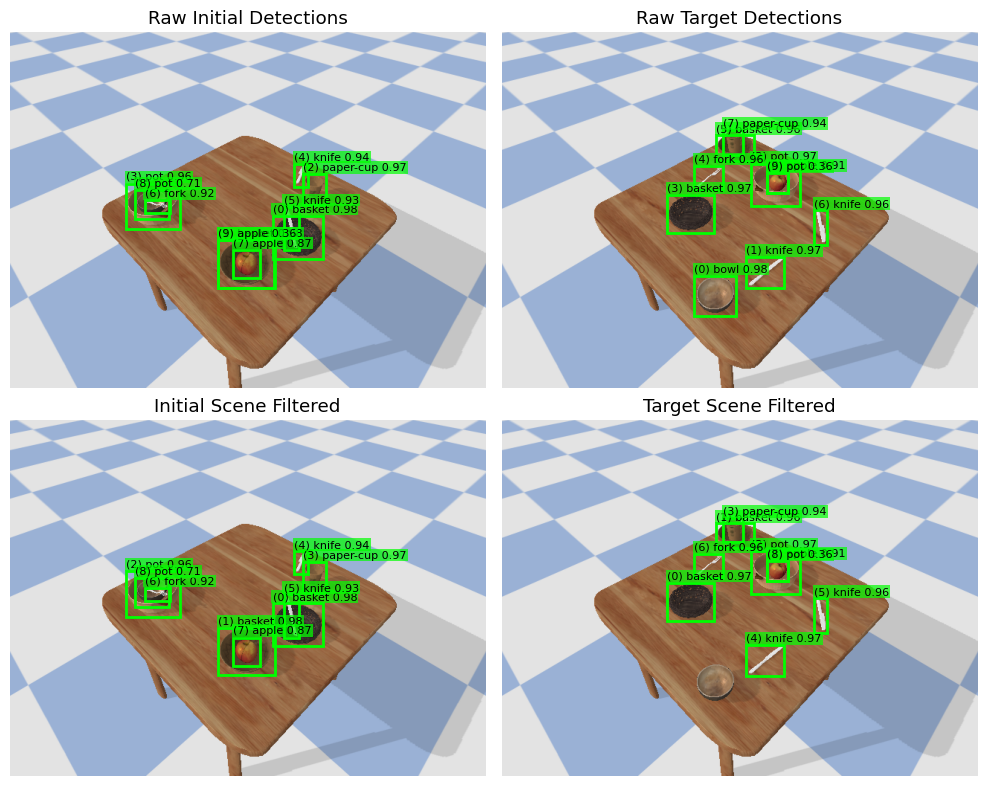

Skipping scene './dataset-sim\rearrangement_02141' due to error in initial detections: Class mismatch. GT: Counter({1: 1, 9: 1, 4: 1, 7: 1, 6: 1, 2: 1, 0: 1}), Det: Counter({2: 1, 4: 1, 0: 1, 7: 1, 1: 1, 9: 1})


11 -------------------------rearrangement_02451-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(1, 5)]
  - Detected:     [(1, 5)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: No stacks
  - Detected:     No stacks
  - ✅ Correct
---------------------------------



12 -------------------------rearrangement_02489-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(6, 4), (8, 1)]
  - Detected:     [(6, 4), (8, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(2, 3), (8, 0)]
  - Detected:     [(2, 5), (8, 0)]
  - ❌ Incorrect
    - Missing relations: [(2, 3)]
    - Extra relations:   [(2, 5)]
------

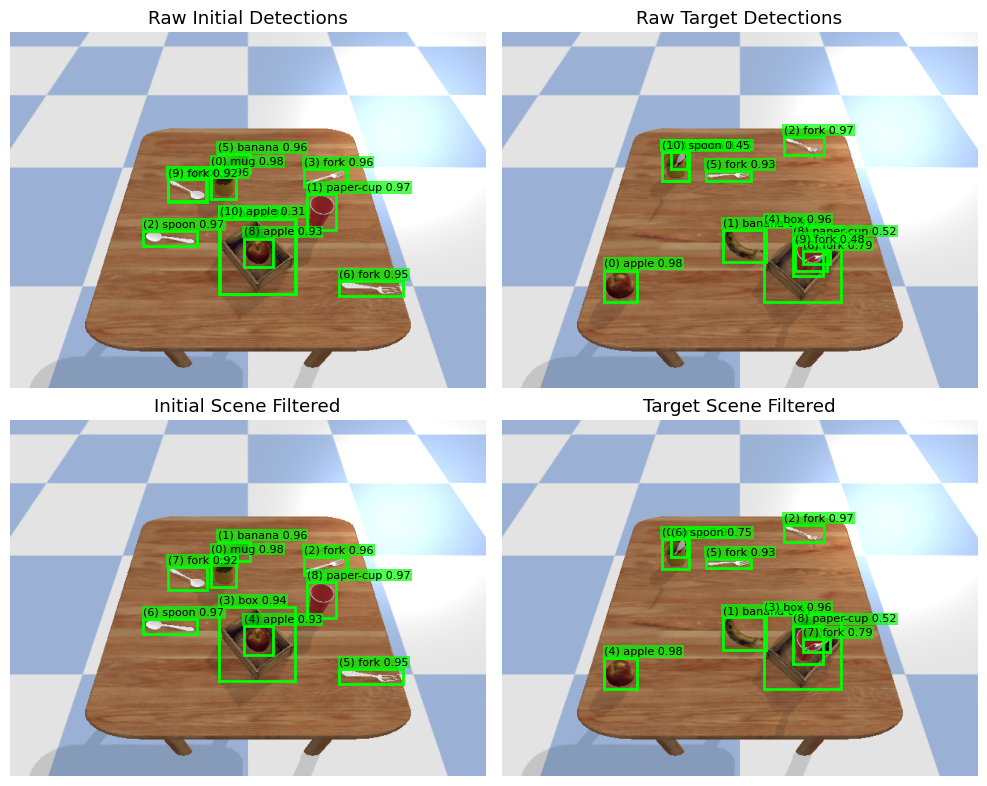

Skipping scene './dataset-sim\rearrangement_02058' due to error in initial detections: Mismatch in object count for class 10. Expected 2, detected 1.


16 -------------------------rearrangement_02019-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(7, 5)]
  - Detected:     [(7, 5)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(7, 5)]
  - Detected:     [(1, 5)]
  - ❌ Incorrect
    - Missing relations: [(7, 5)]
    - Extra relations:   [(1, 5)]
---------------------------------



17 -------------------------rearrangement_02005-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(6, 5)]
  - Detected:     [(6, 5)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(0, 1), (4, 7), (6, 2)]
  - Detected:     [(0, 1), (4, 7), (6, 2)]
  - ✅ Correct
---------------------------------



18 -------------------------rear

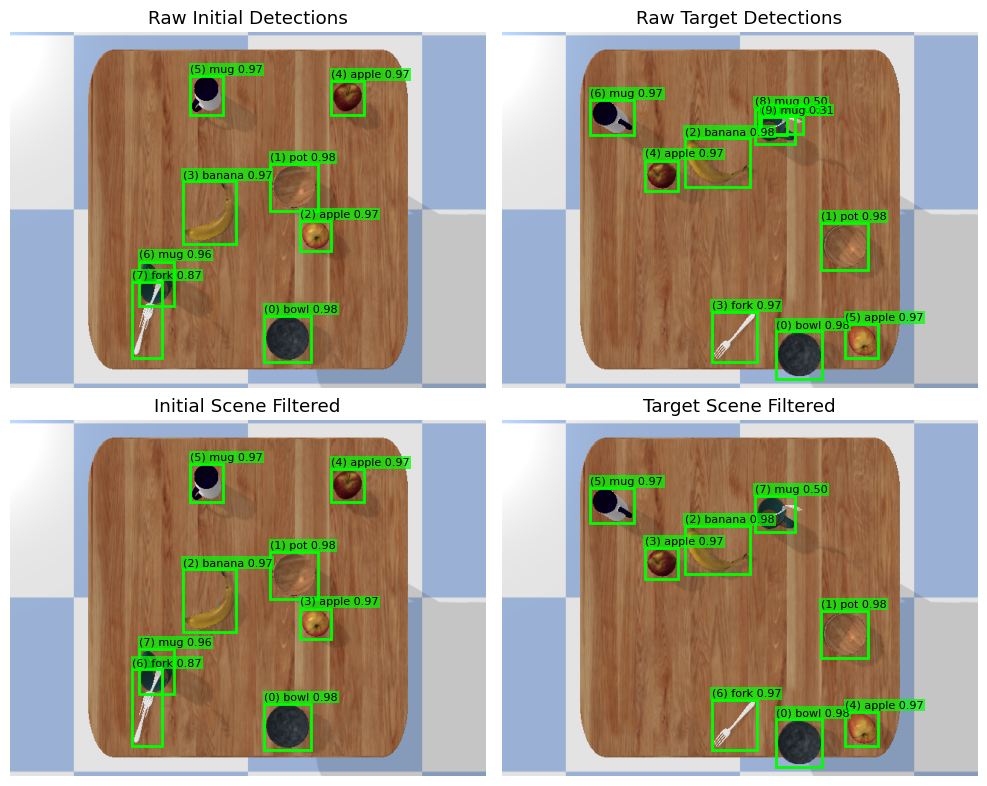

Skipping scene './dataset-sim\rearrangement_02092' due to error in initial detections: Mismatch in object count. Expected 9, but detected 8.


32 -------------------------rearrangement_02347-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(2, 0), (4, 1), (7, 2)]
  - Detected:     [(2, 0), (4, 1), (7, 2)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(7, 1), (8, 3)]
  - Detected:     [(4, 1), (8, 3)]
  - ❌ Incorrect
    - Missing relations: [(7, 1)]
    - Extra relations:   [(4, 1)]
---------------------------------



33 -------------------------rearrangement_02228-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(5, 1)]
  - Detected:     [(5, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(4, 2), (8, 1)]
  - Detected:     [(4, 2), (8, 1)]
  - ✅ Correct
---------------------------------



34 ------

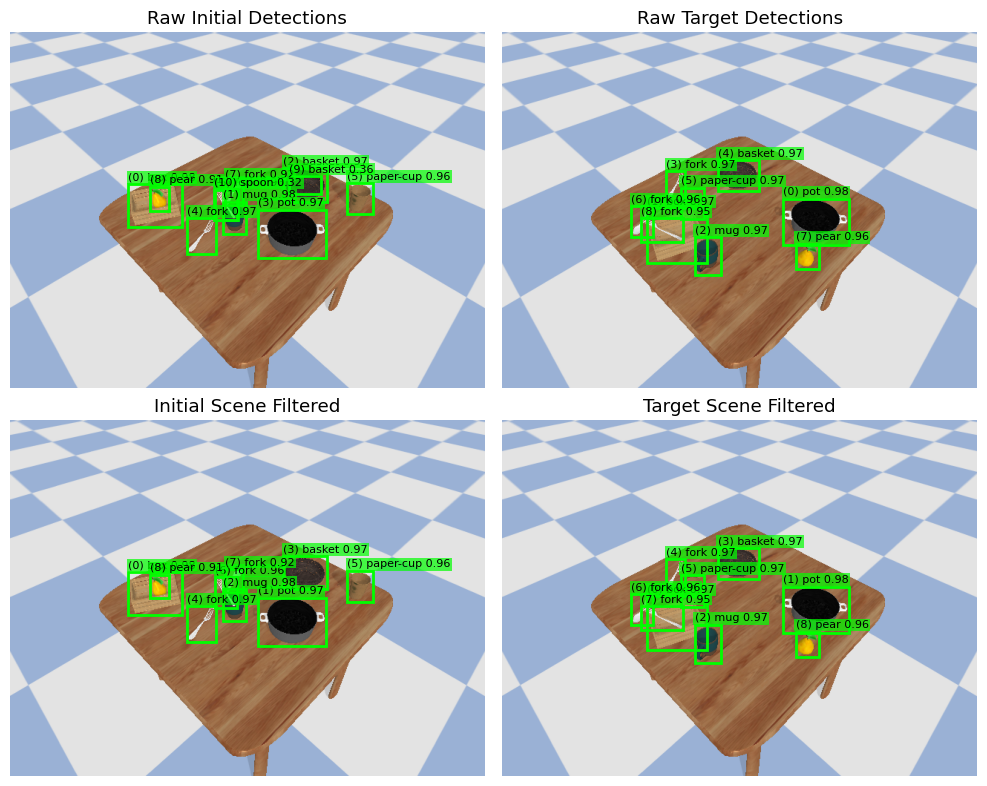

Skipping scene './dataset-sim\rearrangement_02064' due to error in initial detections: Class mismatch. GT: Counter({2: 1, 10: 1, 4: 1, 3: 1, 1: 1, 11: 1, 8: 1, 0: 1}), Det: Counter({3: 1, 4: 1, 8: 1, 2: 1, 1: 1, 0: 1, 11: 1})


38 -------------------------rearrangement_02303-------------------------

Pipeline complete. Final object count: 10.


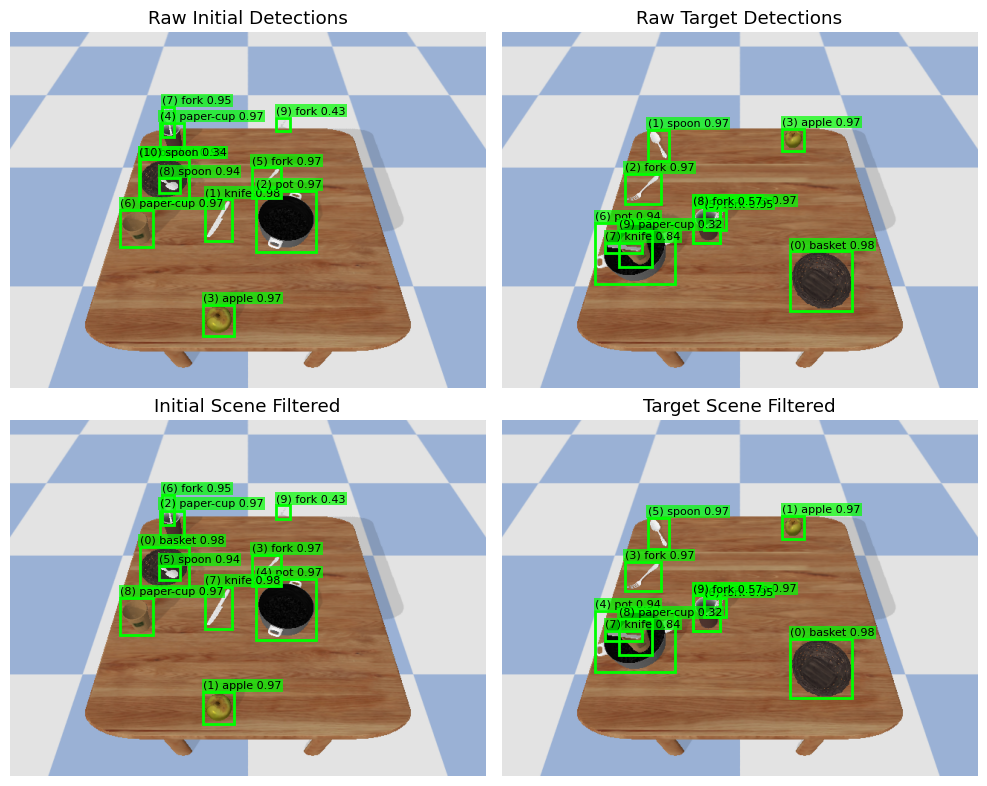

Skipping scene './dataset-sim\rearrangement_02303' due to error in initial detections: Mismatch in object count. Expected 9, but detected 10.


39 -------------------------rearrangement_02208-------------------------

Pipeline complete. Final object count: 9.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(3, 2), (4, 1)]
  - Detected:     [(3, 2), (4, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth: [(6, 2)]
  - Detected:     [(6, 2)]
  - ✅ Correct
---------------------------------





In [47]:
import json
import random

num_samples = 40
json_file_path = 'val_roots.json'
with open(json_file_path, 'r') as f:
	data = json.load(f)

rearrangement_items = [item for item in data if isinstance(item, str) and item.startswith("rearrangement_") and int(item.split('_')[-1]) >= 2000]
sampled_items = random.sample(rearrangement_items, num_samples)
report_file = "results.json"
with open(report_file, 'w') as f:
	f.write('')
confidence_thresh, same_class_iou_thresh, cross_class_iou_thresh = 0.3, 0.7, 0.7
for i, item in enumerate(sampled_items):
	print(i, "-" * 25 + item + "-" * 25 + "\n")
	scene_id = int(item.split('_')[-1])
	folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=scene_id, viewpoint_id=None)
	# visualize_rearrangement(dataset_dir, scene_id=scene_id)

	result = scene_perception(
		yolo, model, folder_path, class_map, 
		confidence_thresh=confidence_thresh, 
		same_class_iou_thresh=same_class_iou_thresh, 
		cross_class_iou_thresh=cross_class_iou_thresh,
		confusable_groups=confusable_groups, verbose=1
	)

	# store the results in a json file
	with open(report_file, 'a') as f:
		json.dump({scene_id: result}, f)
		f.write('\n')
	print("\n" + "=" * 80 + "\n")


# Image2Scene

In [ ]:
import time
import pandas as pd
from core.env.scene_utils import create_scene_meta
from core.planners.plan_optimizer import plan_refinement
from core.planners.planning_utils import evaluate_alg
from core.env.scene_manager import SceneManager
from core.planners.Strap import StrapGA_S
from core.sim.rearrangemet_loader import grid_to_world_coords
from core.sim.physics_utils import (
    PyBulletSim, load_table_urdf, load_object_urdf, get_object_extents
)
from core.sim.camera_manager import CameraManager
from core.sim.robot_manager import RobotController

def load_scene_objects(objects_dir, rearrangement_path, scene="initial"):
	"""
	Loads scene objects from label files and returns them in the same format as generate_scene_objects_from_meta.
	scene: "initial" or "target"
	"""
	label_path = os.path.join(rearrangement_path, f"{scene}_labels.json")
	if not os.path.exists(label_path):
		raise FileNotFoundError(f"{scene.capitalize()} labels file not found: {label_path}")

	meta_path = os.path.join(rearrangement_path, f"meta.json")
	if not os.path.exists(meta_path):
		raise FileNotFoundError(f"Meta file not found: {meta_path}")

	with open(label_path, 'r') as f:
		labels = json.load(f)

	with open(meta_path, 'r') as f:
		meta_data = json.load(f)

	if isinstance(labels, list):
		object_labels = labels
	else:
		object_labels = labels['objects']

	objects = []
	for i, obj in enumerate(object_labels):
		obj_id = obj['obj_id']
		model_name = obj['model_name']
		model_id = obj['model_id']
		body_type = int(model_id.split('_')[-1])
		pos = obj['6D_pose'][:3]
		orn = obj['6D_pose'][3:]

		label = meta_data['objects'][i]['label']
		if scene == "initial":
			base_id = meta_data['objects'][i]['initial_base_id']
		else:
			base_id = meta_data['objects'][i]['target_base_id']

		# Load object in PyBullet
		body_id, _ = load_object_urdf(objects_dir, model_name, pos, orn, body_type=body_type)

		objects.append({
			'object_id': obj_id,
			'label': label,
			'model_name': model_name,
			'pos': pos,
			'base_id': base_id,
			'final_pos': pos,
			'final_orn': orn,
			'body_id': body_id,
			'body_type': body_type,
		})

	# Create a lookup map for objects by their ID
	objects_by_id = {obj['object_id']: obj for obj in objects}

	# Calculate stack hierarchy for each object
	for obj in objects:
		stack_hierarchy = 0
		j = obj['base_id']
		while j is not None:
			stack_hierarchy += 1
			if j in objects_by_id:
				j = objects_by_id[j]['base_id']
			else:
				j = None
		obj['stack_hierarchy'] = stack_hierarchy

	return objects

def manipulate_objects_in_simulation(folder_path, initial_x, target_x, time_limit=5, grid_size=(100, 100),
									 arm_speed=0.3, approach_height=0.4, grasp_height=0.2, place_height=0.2):
	"""
	Simulates the rearrangement plan using a robotic arm in PyBullet.
	"""
	num_objects = initial_x.shape[0]
	env = SceneManager(num_objects=num_objects, grid_size=grid_size, verbose=0)
	env.reset(initial_x, target_x)
	meta_data = create_scene_meta(initial_x, target_x, 0, env.grid_size)
	env.render(fig_size=3)

	plan = evaluate_alg(env, StrapGA_S, initial_x, target_x, time_limit=time_limit, num_buffers=4)
	plan, _, _ = plan_refinement(env, plan, initial_x, target_x, refine_mode="stack", verbose=1)
	
	# sim = PyBulletSim(p.GUI)
	sim = PyBulletSim(p.DIRECT)
	table = load_table_urdf(OBJS_DIR, grid_size)
	x, y, z = get_object_extents(table)
	cam = CameraManager()
	cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)
	env.reset(initial_x, target_x)

	objects = load_scene_objects(OBJS_DIR, folder_path, scene="initial")
	sim.step(2)

	robot = RobotController("franka_panda/panda.urdf", scale=1.5, mode='stationary',
							initial_base_pos=[-0.7, 0, z-0.3], table_size=[x, y])
	# robot.base_speed = 1
	robot.arm_speed = arm_speed
	# robot.base_rotation_speed = 2
	init_pos = [0, 0, z+0.5]
	robot.move_to_position(init_pos)
	robot.open_gripper()
	approach_height = approach_height
	grasp_height = grasp_height
	place_height = place_height

	start_time = time.time()

	for action in plan:
		action_type, obj_idx1, obj_idx2, grid_pos = env.decode_action(action)
		env._step(action_type, obj_idx1, obj_idx2, grid_pos, log=False)

		body_id_1 = objects[obj_idx1]['body_id']
		body_id_2 = objects[obj_idx2]['body_id']
		obj_pos_1, obj_orn_1 = p.getBasePositionAndOrientation(body_id_1)
		obj_pos_2, obj_orn_2 = p.getBasePositionAndOrientation(body_id_2)

		if action_type == 'move':
			target_pos = grid_to_world_coords(grid_pos.tolist(), grid_size=meta_data['grid_size'])
			target_pos = [target_pos[0], target_pos[1], obj_pos_1[2]]
			print(f"moving {obj_idx1} to {target_pos[0]:.2f}, {target_pos[1]:.2f}, {target_pos[2]:.2f}")
			# Pick
			robot.pick_object(body_id_1, approach_height=approach_height, grasp_height=grasp_height)
			# Place
			robot.place_object(target_pos, approach_height=approach_height, place_height=place_height)

		elif action_type == 'stack':
			target_pos = [obj_pos_2[0], obj_pos_2[1], obj_pos_2[2]+0.1]
			print(f"stacking {obj_idx1} on {obj_idx2} at {target_pos[0]:.2f}, {target_pos[1]:.2f}, {target_pos[2]:.2f}")
			# Pick
			robot.pick_object(body_id_1, approach_height=approach_height, grasp_height=grasp_height)
			# Rotate
			if objects[obj_idx2]['model_name'] in ['mug', 'bowl', 'paper-cup']:
				robot.rotate_grasped_object([np.pi/2, 0, 0])
			# Place
			robot.place_object(target_pos, approach_height=approach_height, place_height=place_height)

	end_time = time.time()
	elapsed_time = end_time - start_time
	
	robot.move_to_position(init_pos)
	cam.show_img(cam.capture_image(), title='Achieved Final Scene')

	sim.close()

	return plan, elapsed_time

def read_json_lines(file_path):
    """
    Reads a file where each line is a separate JSON object.

    Args:
        file_path (str): The path to the file to read.

    Yields:
        dict: A dictionary representing the JSON object from a line.
    """
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if line.strip():  # Ensure the line is not empty
                    yield json.loads(line)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON on a line: {e}")

utensils = {'fork', 'knife', 'spoon'}
fruits = {'apple', 'pear'}
bowls = {'bowl', 'pot'}
utensil_group = {k for k, v in class_map.items() if v in utensils}
fruit_group = {k for k, v in class_map.items() if v in fruits}
bowl_group = {k for k, v in class_map.items() if v in bowls}
confusable_groups = [utensil_group, fruit_group, bowl_group]
results_file = "results_sim.json"
output_csv_file = "simulation_results.csv"
if os.path.exists(output_csv_file):
	os.remove(output_csv_file)

for data_object in read_json_lines(results_file):
	scene_id = int(next(iter(data_object)))
	print("\n" + "=" * 80 + "\n")
	print(data_object)
	folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=scene_id)
	visualize_rearrangement(dataset_dir, scene_id=scene_id,figsize=(9, 4))
	result = scene_perception(
		yolo, model, folder_path, class_map, 
		confidence_thresh=0.3, same_class_iou_thresh=0.7, cross_class_iou_thresh=0.7,
		confusable_groups=confusable_groups, verbose=1, return_x=True
	)
	if result == -1:
		print(f"Skipping scene {scene_id} due to errors in perception.")
		continue

	initial_x, target_x = result
	try:
		plan, elapsed_time = manipulate_objects_in_simulation(
			folder_path, initial_x, target_x, time_limit=5, grid_size=(100, 100),
			arm_speed=0.3, approach_height=0.4, grasp_height=0.25, place_height=0.25
		)
	except Exception as e:
		print(f"Error during simulation for scene {scene_id}: {e}")
		continue
	print(f"Simulation time: {elapsed_time:.2f} seconds")
	
	# Store the results in a pandas DataFrame and save to CSV
	df = pd.DataFrame([{
		'scene_id': scene_id,
		'plan_length': len(plan),
		'simulation_time': elapsed_time
	}])
	df.to_csv(output_csv_file, mode='a', header=not os.path.exists(output_csv_file), index=False)
	print(f"Results for scene {scene_id} saved to {output_csv_file}")
